In [7]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [27]:
(train_images, _), (test_images, _) = mnist.load_data()

In [28]:
train_images.shape

(60000, 28, 28)

In [29]:
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)) / 255.
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)) / 255.

In [30]:
train_images.shape

(60000, 28, 28, 1)

In [31]:
test_images.shape

(10000, 28, 28, 1)

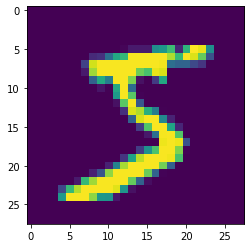

In [32]:
plt.imshow(train_images[0])
plt.show()

In [33]:
train_images = np.where(train_images > 0.5, 1.0, 0.0).astype('float32')

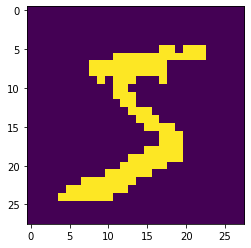

In [34]:
plt.imshow(train_images[0])
plt.show()

In [35]:
test_images = np.where(test_images > 0.5, 1.0, 0.0).astype('float32')

In [36]:
train_size = train_images.shape[0]
batch_size = 32
test_size = test_images.shape[0]
train_df = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_df = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [37]:
class ConvolutionalVariational(Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            InputLayer(input_shape=(28,28,1)),
            Conv2D(filters=32, kernel_size=3, strides=(2,2), activation="relu"),
            Conv2D(filters=64, kernel_size=3, strides=(2,2), activation="relu"),
            Flatten(),
            Dense(latent_dim + latent_dim)
        ])
        
        self.decoder = tf.keras.Sequential([
            InputLayer(input_shape=(latent_dim)),
            Dense(units=7 * 7 * 32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7,7,32)),
            Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding="same", activation="relu"),
            Conv2DTranspose(filters=32, kernel_size=3, strides=(2,2), padding="same", activation="relu"),
            Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same"),
        ])
        
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [48]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal(sample, mean, logvar, axis=1):
    log2pi = tf.math.log(2 * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean) ** 2 * tf.exp(-logvar) + logvar + log2pi), axis=axis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = tf.reduce_sum(cross_entropy, axis=[1,2,3])
    logpz = log_normal(z, 0., 0.)
    logqz_x = log_normal(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    

In [49]:
# first we will call train_Step that will iterate over dataset
# during each iteration we pass image to encoder to obtain mean and log-var of posterior q(z|x)
# the we apply reparameterization to sample from q(z|x)
# finally we pass reparameterized samples to the decoder to obtain logits of generative distribution p(x|z)

In [50]:
epochs = 5
latent_dim = 2
examples_to_gen = 16

random_vector = tf.random.normal(shape=[examples_to_gen, latent_dim])

In [51]:
model = ConvolutionalVariational(latent_dim)

In [52]:
import time
for epoch in range(1, epochs):
    start_time = time.time()
    for train_x in train_df:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_df:
        loss(compute_loss(model, test_x))
        
    elbo = -loss.result()
    print(f"Epoch : {epoch}, Elbo : {elbo}, Time : {end_time - start_time}")

Epoch : 1, Elbo : 737006053228544.0, Time : 25.788212299346924
Epoch : 2, Elbo : 7.653583617838285e+16, Time : 25.47516131401062
Epoch : 3, Elbo : nan, Time : 23.02907371520996


KeyboardInterrupt: 